## Matrix Factorization for Recommender System

MF can be used to **predict** ratings using _explicit feedback_. _Explicit feedback_ includes user ratings, while _implicit feedback_ could be user interactions with the items (clicks, views etc).

With MF, we decompose the original rating matrix `R` into two smaller matrices, user representation `U` and item representation `V`. The respective latent representation can then be used to build the reconstructed rating matrix `R_hat`.

This `R_hat` will contain the predicted ratings for those values that are initially 0.

In short, this method of ratings predictions requires the whole user-item ratings to be known, which can be expensive in real-world applications.

- U is the user matrix of shape (num users, K): where num users = |U|
- V is the item matrix of shape (num items, K): where num items = |V|
- Where K is the number of latent features of U and V
- R is the ground truth ratings matrix of shape (|U|, |V|)
- Finally, R_hat is the reconstructed ratings

## References
- https://medium.com/@maxbrenner-ai/matrix-factorization-for-collaborative-filtering-linear-to-non-linear-models-in-python-5cf54363a03c
- https://sifter.org/simon/journal/20061211.html

In [24]:
import matplotlib.pyplot as plt
import numpy as np

We train the model by minimizing the mean square error loss for every iteration:

$MSE = \frac{1}{N}\sum^N_{i=1}[R_i-\hat{R_i}]^2$

In order to calculate the loss, this cost function above must be differentiable:

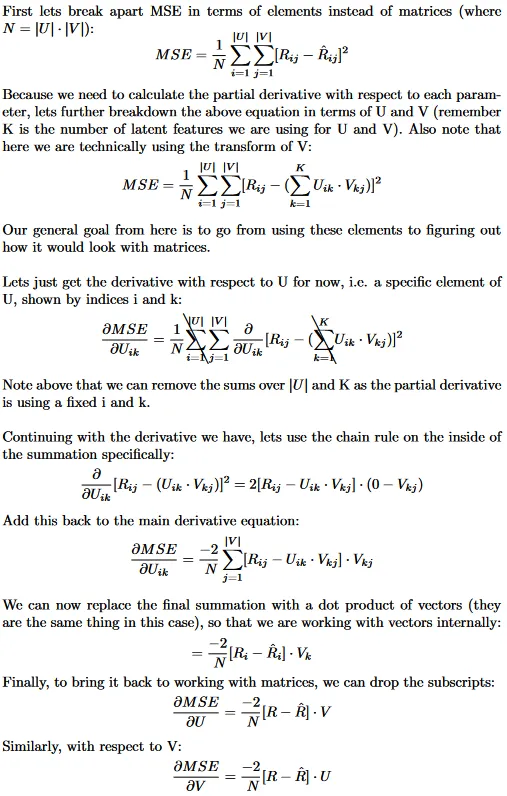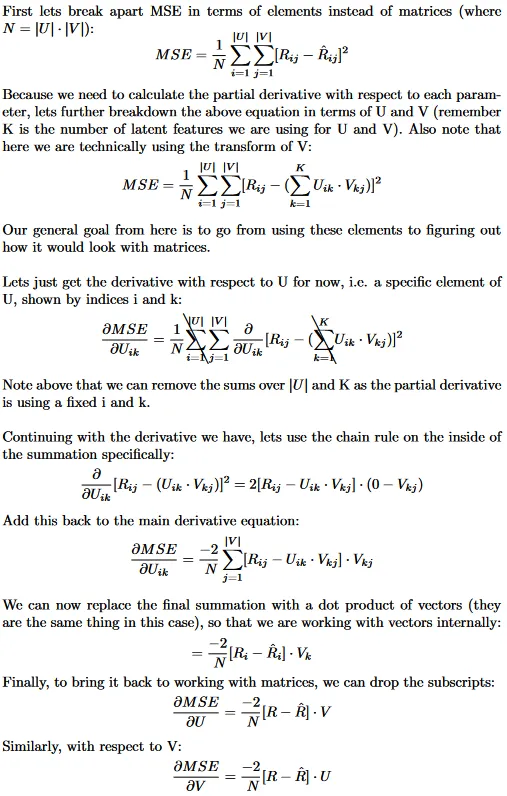


We can then update equation for `U` and `V`, where `alpha` is the learning rate:
    
$U = U - \alpha\frac{\partial\text{MSE}}{\partial\text{U}}$

$V = V - \alpha\frac{\partial\text{MSE}}{\partial\text{V}}$

In [384]:
R = np.array(
    [
        [5, 3, 0, 1],
        [4, 0, 0, 1],
        [1, 1, 0, 5],
        [1, 0, 0, 4],
        [0, 1, 5, 4],
    ],
    dtype=float,
)


n_user, n_item = R.shape
K = min(R.shape) - 1  # Latent factor size

# Initialize the U, V with random values.
# We will learn the values by training.
U = np.random.uniform(0, 1, (n_user, K))
V = np.random.uniform(0, 1, (n_item, K))
N = n_user * n_item


user_indices, item_indices = R.nonzero()
losses = []
mask = R > 0
known_ratings = np.sum(mask)
reg = 0.02

T = 500  # Epochs
alpha = 0.1  # learning rate
tol = 1e-3

for t in range(T):
    # Yes, we are looping it individually.
    # It makes sense since ratings matrix will usually be sparse - you can have thousands of movies,
    # but not all will be rated by users.
    for i, j, r in zip(user_indices, item_indices, R[user_indices, item_indices]):
        r_hat = U[i] @ V[j].T
        err = r - r_hat

        # Instead of -2.0/N like the literature, we just include all the constants
        U[i] += alpha * (err * V[j] - reg * U[i])
        V[j] += alpha * (err * U[i] - reg * V[j])

        # The loss should decrease over time.
    err = R - U @ V.T
    # The mean square error is calculated by including only the known ratings.
    # We ignore the initial zero values, since they will be filled.
    # loss = np.square(err[mask]).sum() + alpha * (np.square(U).sum() + np.square(V).sum())
    loss = np.square(err[mask]).sum() / known_ratings
    losses.append(loss)
    if t % 100 == 0:
        print("Iter", t, loss)

    # It is important to set a tolerance value, as too many iterations will lead
    # to numerical instability.
    # Also, the predicted ratings will go out of range easily (<0, >5)
    if loss < tol:
        print("Terminate after", t, "iterations", loss)
        break

Iter 0 4.2125004476733405
Terminate after 16 iterations 0.0009755685292567753


Text(0, 0.5, 'MSE')

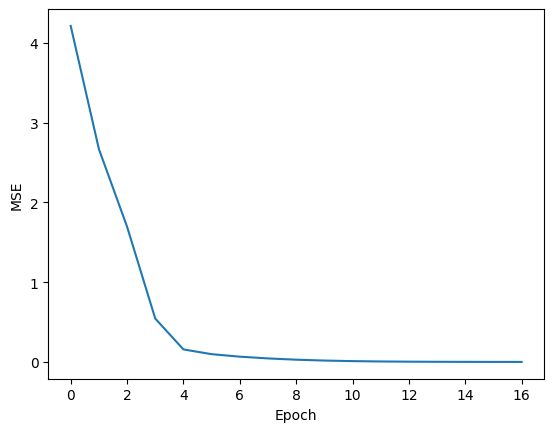

In [385]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [386]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [387]:
R_hat = U @ V.T
print(np.round(R_hat, 2))

[[4.96 2.94 4.36 1.  ]
 [3.95 2.14 3.63 1.  ]
 [1.03 0.95 3.63 4.98]
 [1.   0.53 3.1  3.98]
 [3.27 1.03 4.99 3.99]]


### Output

In [250]:
# If the replace does not work, check if the data type for R matches R_hat, which is float.
# If the data type of the matrix to replace does not match, it will silently failed.
mask = R == 0
R[mask] = R_hat[mask]
np.round(np.clip(R, 0, 5), 2)

array([[5.  , 3.  , 5.  , 1.  ],
       [4.  , 1.64, 4.57, 1.  ],
       [1.  , 1.  , 3.35, 5.  ],
       [1.  , 0.12, 2.67, 4.  ],
       [3.24, 1.  , 5.  , 4.  ]])

## Using Keras

In TensorFlow 2.x, you can use `tf.GradientTape` to automatically compute the gradients for a matrix factorization model with mean squared error loss. Here's an example:

In this example, we first initialize user and item embedding matrices `U` and `V`. We then define a mean squared error loss function `mse_loss`, which computes the prediction matrix as the matrix product of `U` and `V`, and then computes the squared difference between the prediction matrix and the actual ratings matrix `R`. The loss is only computed for the non-zero entries of `R`.

We then use `tf.GradientTape` to compute the gradients of the loss with respect to the embedding matrices, and use the optimizer to apply these gradients. This is done in a loop for a fixed number of iterations.

In [312]:
import tensorflow as tf

R = tf.constant(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=tf.float32,
)
n_user, n_item = R.shape
non_zero_mask = tf.math.not_equal(R, 0)
indices = tf.where(non_zero_mask)
known_ratings = len(indices)
N = n_user * n_item
K = 3

U = tf.Variable(tf.random.normal([n_user, K], stddev=0.1))
V = tf.Variable(tf.random.normal([n_item, K], stddev=0.1))

T = 500  # Epochs
alpha = 0.1  # Learning rate
tol = 1e-3

losses = []
optimizer = tf.keras.optimizers.SGD(learning_rate=alpha)

# Define the loss function
def mse_loss(U, V, R):
    R_hat = tf.matmul(U, V, transpose_b=True)
    # return tf.keras.metrics.mean_squared_error(R, R_hat)
    non_zero_mask = tf.math.not_equal(R, 0)
    loss = tf.reduce_sum(tf.square(R - R_hat) * tf.cast(non_zero_mask, tf.float32))
    return loss / known_ratings


for t in range(T):
    for i, j in indices:
        r = R[i, j]
        with tf.GradientTape() as tape:
            # Compute the dot product between the user and item embeddings
            r_hat = tf.tensordot(U[i], V[j], axes=1)

            # Compute the squared error loss
            loss = tf.square(r - r_hat)

        # Compute the gradients
        dU, dV = tape.gradient(loss, [U, V])

        # Apply the gradients

        U.assign(tf.tensor_scatter_nd_update(U, [[i]], [U[i] - lr * dU[i]]))
        V.assign(tf.tensor_scatter_nd_update(V, [[j]], [V[j] - lr * dV[j]]))

    loss = mse_loss(U, V, R)
    losses.append(loss)
    if t % 100 == 0:
        print(t, loss)
    if loss.numpy() < tol:
        print("Terminated after", t, "iterations. MSE:", loss)
        break

0 tf.Tensor(10.550483, shape=(), dtype=float32)
100 tf.Tensor(0.0051628468, shape=(), dtype=float32)
Terminated after 135 iterations. MSE: tf.Tensor(0.0009698805, shape=(), dtype=float32)


Text(0, 0.5, 'MSE')

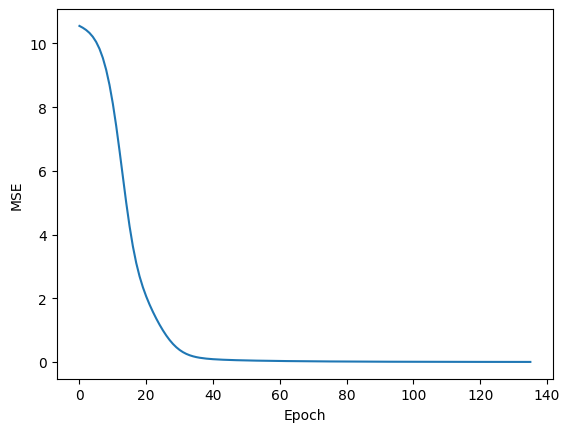

In [313]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [314]:
R = R.numpy()
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

### Reconstructed Ratings

In [315]:
R_hat = tf.matmul(U, V, transpose_b=True).numpy()
np.round(R_hat, 2)

array([[5.01, 2.99, 4.11, 1.  ],
       [3.99, 2.31, 3.49, 1.  ],
       [1.03, 0.93, 5.28, 5.  ],
       [0.99, 0.72, 4.37, 3.99],
       [1.84, 1.08, 4.98, 4.01]], dtype=float32)

In [316]:
mask = R == 0
R[mask] = R_hat[mask]
np.round(np.clip(R, 0, 5), 1)

array([[5. , 3. , 4.1, 1. ],
       [4. , 2.3, 3.5, 1. ],
       [1. , 1. , 5. , 5. ],
       [1. , 0.7, 4.4, 4. ],
       [1.8, 1. , 5. , 4. ]], dtype=float32)

### Output

In [13]:
# We still have issue with negative values, and some values goes beyond 5.
np.round(np.clip(R, 0, 5), 1)

array([[5. , 3. , 3.9, 1. ],
       [4. , 2.4, 3.3, 1. ],
       [1. , 1. , 5. , 5. ],
       [1. , 0.9, 4.8, 4. ],
       [1.2, 1. , 5. , 4. ]], dtype=float32)

The output should match the one done with numpy.

In [18]:
np.round(U @ V.T, 2)

array([[ 5.  ,  3.  ,  4.08,  1.  ],
       [ 4.  ,  0.51,  2.89,  1.  ],
       [ 1.  ,  1.  ,  3.38,  5.  ],
       [ 1.  , -1.49,  2.23,  4.  ],
       [ 4.81,  1.  ,  5.  ,  4.  ]])

In [19]:
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

## Tensorflow

In [330]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Flatten, Input
from tensorflow.keras.optimizers import SGD

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Get the number of users and items
num_users, num_items = R.shape

# Get the indices of non-zero entries
user_ids, item_ids = np.nonzero(R)

# Get the corresponding ratings
ratings = R[user_ids, item_ids]

# Define the embedding dimension
embedding_dim = 3

# Define the inputs
user_input = Input(shape=(1,), dtype=tf.int32)
item_input = Input(shape=(1,), dtype=tf.int32)

# Define the user and item embeddings
user_embedding = Embedding(
    input_dim=num_users, output_dim=embedding_dim, name="user_embeddings"
)(user_input)
item_embedding = Embedding(
    input_dim=num_items, output_dim=embedding_dim, name="item_embeddings"
)(item_input)

# Flatten the embeddings
user_embedding = Flatten()(user_embedding)
item_embedding = Flatten()(item_embedding)

# Compute the dot product between the user and item embeddings
rating_prediction = tf.reduce_sum(user_embedding * item_embedding, axis=1)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=rating_prediction)

# Compile the model
model.compile(loss="mean_squared_error", optimizer=SGD())

# Fit the model
model.fit([user_ids, item_ids], ratings, epochs=500, verbose=0)

In [331]:
# Assume we want to predict the rating for the first user and the first item
user_id = np.array([0])
item_id = np.array([0])

# Predict the rating
predicted_rating = model.predict([user_id, item_id])

print("Predicted rating:", predicted_rating[0])

1/1 [==============================] - 0s 83ms/step
Predicted rating: 4.8853264


In [332]:
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

### Reconstructed Rating

In [333]:
# Get the user and item embeddings
user_embeddings = model.get_layer(name="user_embeddings").get_weights()[0]
item_embeddings = model.get_layer(name="item_embeddings").get_weights()[0]

# Compute the dot product between the user and item embeddings
predicted_ratings = user_embeddings @ item_embeddings.T

print("Predicted ratings matrix:")
print(np.round(predicted_ratings, 2))

Predicted ratings matrix:
[[ 4.89  2.41 -0.88  1.48]
 [ 3.6   1.79 -0.55  1.21]
 [ 1.34  1.39  2.76  4.22]
 [ 1.27  1.2   2.16  3.43]
 [-0.51  0.68  3.96  4.75]]


In [350]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 user_embeddings (Embedding  (None, 1, 3)                 15        ['input_9[0][0]']             
 )                                                                                                
                                                                                                  
 item_embeddings (Embedding  (None, 1, 3)                 12        ['input_10[0][0]']      

## Alternating Least Squares

Alternating Least Squares (ALS) and Stochastic Gradient Descent (SGD) are two different methods for optimizing the matrix factorization problem in recommender systems.

ALS works by fixing one set of variables (e.g., user embeddings) and solving for the other set of variables (e.g., item embeddings), then alternating between the two sets of variables until convergence. This makes the optimization problem convex and easier to solve, but it requires computing the inverse of a matrix, which can be computationally expensive for large matrices.

SGD, on the other hand, works by randomly initializing both sets of variables and then iteratively updating each variable in the direction that reduces the error. This makes the optimization problem non-convex and potentially harder to solve, but it doesn't require computing the inverse of a matrix, which makes it more scalable for large matrices.



References:
- http://activisiongamescience.github.io/2016/01/11/Implicit-Recommender-Systems-Biased-Matrix-Factorization/

Some good libraries
- https://surpriselib.com/
- https://github.com/online-ml/river/tree/main (includes online bandit!)

Keras is a high-level neural networks API, and it doesn't directly support Alternating Least Squares (ALS) as it's not a neural network-based method. ALS is a matrix factorization method used in collaborative filtering for making recommendations, which is a different kind of method compared to what Keras is designed for.

However, you can implement a kind of alternating optimization using Keras by training two models separately: one model for user embeddings and another for item embeddings. Here's a rough example:

In [353]:
import numpy as np
from tensorflow.keras.layers import Embedding, Flatten, Input, dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Get the number of users and items
num_users, num_items = R.shape

# Get the indices of non-zero entries
user_ids, item_ids = np.nonzero(R)

# Get the corresponding ratings
ratings = R[user_ids, item_ids]

# Define the embedding dimension
embedding_dim = min(R.shape) - 1

# Define the inputs
user_input = Input(shape=(1,), dtype="int32")
item_input = Input(shape=(1,), dtype="int32")

# Define the user and item embedding layers
user_embedding = Embedding(output_dim=embedding_dim, input_dim=num_users)(user_input)
item_embedding = Embedding(output_dim=embedding_dim, input_dim=num_items)(item_input)

# Flatten the embeddings
user_embedding = Flatten()(user_embedding)
item_embedding = Flatten()(item_embedding)

# Compute the dot product between the user and item embeddings
rating_prediction = dot([user_embedding, item_embedding], axes=1)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=rating_prediction)

# Compile the model
model.compile(loss="mean_squared_error", optimizer=SGD())

# Fit the model
for epoch in range(500):
    # Fix item embeddings and train user embeddings
    model.layers[2].trainable = False
    model.layers[3].trainable = True
    model.fit([user_ids, item_ids], ratings, epochs=1, verbose=0)

    # Fix user embeddings and train item embeddings
    model.layers[2].trainable = True
    model.layers[3].trainable = False
    model.fit([user_ids, item_ids], ratings, epochs=1, verbose=0)

    if epoch % 100 == 0:
        loss = model.evaluate([user_ids, item_ids], ratings, verbose=0)
        print("Epoch", epoch, "Loss", loss)

Epoch 0 Loss 10.619391441345215
Epoch 100 Loss 10.456918716430664
Epoch 200 Loss 3.426332950592041
Epoch 300 Loss 0.45262324810028076
Epoch 400 Loss 0.04471496865153313


In [354]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 3)                 15        ['input_11[0][0]']            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 3)                 12        ['input_12[0][0]']            
                                                                                            

In [361]:
user_embedding = model.get_layer("embedding").weights[0].numpy()
item_embedding = model.get_layer("embedding_1").weights[0].numpy()

np.round(user_embedding @ item_embedding.T, 2)

array([[5.06, 2.9 , 2.61, 0.98],
       [3.96, 2.28, 2.25, 0.98],
       [1.06, 0.84, 5.28, 4.93],
       [0.99, 0.75, 4.25, 3.93],
       [1.82, 1.23, 4.8 , 4.21]], dtype=float32)

In [362]:
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

## Using Keras, whole matrix

In [388]:
import numpy as np
import tensorflow as tf

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Get the number of users and items
num_users, num_items = R.shape

# Get the indices of non-zero entries
user_ids, item_ids = np.nonzero(R)

# Get the corresponding ratings
ratings = R[user_ids, item_ids]

# Define the embedding dimension
embedding_dim = min(R.shape) - 1

# Initialize user and item embedding matrices
U = tf.Variable(tf.random.uniform((num_users, embedding_dim)))
V = tf.Variable(tf.random.uniform((num_items, embedding_dim)))

# Define the learning rate
lr = 0.1

# Define the number of epochs
epochs = 500

# Define the optimizer
optimizer = tf.optimizers.SGD(lr)

# Run the optimization
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute the dot product between the user and item embeddings
        prediction = tf.reduce_sum(
            tf.gather(U, user_ids) * tf.gather(V, item_ids), axis=1
        )

        # Compute the mean squared error loss
        loss = tf.reduce_mean((ratings - prediction) ** 2)

    # Compute the gradients
    grads = tape.gradient(loss, [U, V])

    # Apply the gradients
    optimizer.apply_gradients(zip(grads, [U, V]))

    if epoch % 100 == 0:
        print("Epoch", epoch, "Loss", loss.numpy())

Epoch 0 Loss 5.7831674
Epoch 100 Loss 0.009948074
Epoch 200 Loss 6.8908565e-05
Epoch 300 Loss 3.1928224e-07
Epoch 400 Loss 1.4373435e-09


In [392]:
np.round(U.numpy() @ V.numpy().T, 2)

array([[5.  , 3.  , 4.85, 1.  ],
       [4.  , 2.15, 4.13, 1.  ],
       [1.  , 1.  , 4.1 , 5.  ],
       [1.  , 0.5 , 3.64, 4.  ],
       [2.44, 1.  , 5.  , 4.  ]], dtype=float32)

## Numpy full matrix

In [394]:
R = np.array(
    [
        [5, 3, 0, 1],
        [4, 0, 0, 1],
        [1, 1, 0, 5],
        [1, 0, 0, 4],
        [0, 1, 5, 4],
    ],
    dtype=float,
)


n_user, n_item = R.shape
K = min(R.shape) - 1  # Latent factor size

# Initialize the U, V with random values.
# We will learn the values by training.
U = np.random.uniform(0, 1, (n_user, K))
V = np.random.uniform(0, 1, (n_item, K))
N = n_user * n_item


user_indices, item_indices = R.nonzero()
losses = []
mask = R > 0
known_ratings = np.sum(mask)
reg = 0.02

T = 500  # Epochs
alpha = 0.1  # learning rate
tol = 1e-3

for t in range(T):
    R_hat = U @ V.T
    err = R - R_hat

    # Instead of -2.0/N like the literature, we just include all the constants
    U += alpha * (err @ V - reg * U)
    V += alpha * (err.T @ U - reg * V)

    loss = np.square(err[mask]).sum() / known_ratings
    losses.append(loss)
    if t % 100 == 0:
        print("Iter", t, loss)

    if loss < tol:
        print("Terminate after", t, "iterations", loss)
        break

Iter 0 7.54687845562033
Iter 100 0.10489907505360843
Iter 200 0.10490434157892338
Iter 300 0.10490675052631726
Iter 400 0.1049078458150461


In [396]:
np.round(U @ V.T, 2)

array([[ 5.31,  2.18,  0.18,  1.  ],
       [ 3.46,  1.32, -0.3 ,  0.99],
       [ 1.19,  0.52,  0.11,  4.99],
       [ 0.86,  0.34, -0.07,  3.99],
       [-0.05,  1.12,  4.95,  3.99]])